# Hate Speech Detector 2.0
---
**Researching experiments**

1. Load 16,000 training and 1,000 test examples and utilize best hate speech detection model (**Simple Recurrent Neural Network**) with default params and hyperparams.
2. Perform following experiments for parameters:
    1. Train above model for different values of **number of recurrent layers** (10 values) and **bidirectioning** (2 options).
    2. -------------------||-------------------- **dropout** (10 values) and **recurrent unit** (3 items).
3. Perform following experiments for hyperparameters:
    1. Train above model for different values of **regularization** (10 values) **learning rate** (3 values).
    2. -------------------||-------------------- **learning rate scheduler** (4 items) and **optimizer** (3 items).
4. For each experiment predict hate speech for 1000 test tweets for each trained model and save results into appropriate .csv files.
5. Make appropriate visualizations (bar plots with lines).

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import torch

from src.classifiers.DLVectorClassifier import DLVectorClassifier
from src.vectorizers.TextOwnTrainedFTVectorizer import TextOwnTrainedFTVectorizer
from src.nn.models import RecurrentNet
from src.dataframes.utils import classes, combine_row_wisely, shuffle_dataframe, class_weights
from src.experiments import quality_measures, experimental_result_lines, experimental_measure_lines
from src.constants import (LABELS, LABELS_QM_SMALL, LABELS_SMALL,
                           DUPLICATED_PATH, COMBINED_TESTONLY_PATH,
                           EXPERIMENT_RESULTS_DIR, EXPERIMENT_CHART_DIR)

In [2]:
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings(action='ignore', category=ConvergenceWarning)
pd.options.mode.chained_assignment = None

In [3]:
EXPERIMENT = 'E3'
WEIGHT_TYPE = 2

In [4]:
plt.style.use('ggplot')

In [5]:
DEFAULT_HYPERPARAMS = dict({
    '_optim': torch.optim.Adam,
    '_optim_params': dict({
        'lr': 0.0005,
        'weight_decay': 0.0005
    }),
    '_sched': torch.optim.lr_scheduler.LambdaLR,
    '_sched_params': dict({
        'lr_lambda': lambda e: 0.65 * e
    }),
})
BEST_MODEL_PARAMS = dict({
    'k_folds': 5,
    'vec_class': TextOwnTrainedFTVectorizer,
    'nn_class': RecurrentNet,
    'nn_type': 'recurrent_w2',
    'vec_params': dict({
        'model_type': 's',
        'short_name': 'super'
    }),
    'nn_hparams': DEFAULT_HYPERPARAMS,
    'nn_params': dict({
        'n_layers': 5,
        'drop_prob': 0.1,
        'bidirectional': False
    }),
})

## Data loading

### Classes

In [6]:
df_classes = pd.read_csv(DUPLICATED_PATH)[LABELS]
df_classes.head(2)

,wyzywanie,grożenie,wykluczanie,odczłowieczanie,poniżanie,stygmatyzacja,szantaż
0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0


In [7]:
df_test_classes = pd.read_csv(COMBINED_TESTONLY_PATH)[LABELS]
df_test_classes = classes(df_test_classes, convert_null=True)
df_test_classes.head(2)

,wyzywanie,grożenie,wykluczanie,odczłowieczanie,poniżanie,stygmatyzacja,szantaż
0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0


### Lemmatized tweets

In [8]:
df_lemmatized = pd.read_csv(DUPLICATED_PATH)[['tweet']]
df_lemmatized.head(2)

,tweet
0,w czwartek muszę poprawić sądy i trybunały
1,Żale Nałęcza i riposta Macierewicza: Pan był w...


In [9]:
df_test_lemmatized = pd.read_csv(COMBINED_TESTONLY_PATH)[['tweet']]
df_test_lemmatized.head(2)

,tweet
0,"Warto poznać Śląsk i Ślązaków, zanim zacznie s..."
1,jeszcze nie są całkiem bezkarni.Sądy jeszcze t...


### Combined data

In [10]:
df_data = combine_row_wisely([df_lemmatized, df_classes])
df_data = shuffle_dataframe(df_data)
df_data.head(2)

,tweet,wyzywanie,grożenie,wykluczanie,odczłowieczanie,poniżanie,stygmatyzacja,szantaż
10564,no sądy (nie tylko lustracyjne) to trzeba zao...,0,1,0,0,0,0,0
3419,"W 2014 r. służby, sądy i prokuratury złożyły ł...",0,0,0,0,0,0,0


In [11]:
df_test_data = combine_row_wisely([df_test_lemmatized, df_test_classes])
df_test_data.head(2)

,tweet,wyzywanie,grożenie,wykluczanie,odczłowieczanie,poniżanie,stygmatyzacja,szantaż
0,"Warto poznać Śląsk i Ślązaków, zanim zacznie s...",0,0,0,0,0,0,0
1,jeszcze nie są całkiem bezkarni.Sądy jeszcze t...,0,0,0,0,0,0,0


### Class weights

In [12]:
weights = class_weights(df_classes, w_type=WEIGHT_TYPE)
BEST_MODEL_PARAMS['weights'] = weights
weights

array([1.96630992, 1.95459439, 1.9713761 , 1.9734659 , 1.9341397 ,
       1.93059338, 1.99620037])

## Models training and testing

In [13]:
# researched params
regularizations = list(np.arange(0.005, 0.055, 0.005))
learning_rates = list(np.arange(0.005, 0.02, 0.005))

In [14]:
X_data = df_data.drop(LABELS, axis=1).values
y_data = df_data[LABELS].values

X_test_data = df_test_data.drop(LABELS, axis=1).values
y_test_data = df_test_data[LABELS].values

headers = list(['regularization', 'learning rate'] + LABELS_QM_SMALL)
results = list([])

In [15]:
for lr in tqdm(learning_rates, leave=None):
    for reg in tqdm(regularizations, leave=None):
        params = BEST_MODEL_PARAMS.copy()
        params['short_name'] = EXPERIMENT
        params['nn_hparams']['_optim_params']['lr'] = lr
        params['nn_hparams']['_optim_params']['weight_decay'] = reg
        
        clf = DLVectorClassifier(**params)
        clf.fit(X_data, y_data)
        
        y_pred = clf.predict(X_test_data)
        qm = quality_measures(y_trues=y_test_data, y_preds=y_pred)
        
        results.append([reg, lr] + list(qm))

results = np.array(results)

In [16]:
df_results = pd.DataFrame(results, columns=headers)
df_results.to_csv(EXPERIMENT_RESULTS_DIR.replace('{}', f'{EXPERIMENT}'), index=False)
df_results

,regularization,learning rate,wyz_a,wyz_p0,wyz_p1,wyz_r0,wyz_r1,wyz_f0,wyz_f1,groz_a,...,szan_r1,szan_f0,szan_f1,all_a,all_p0,all_p1,all_r0,all_r1,all_f0,all_f1
0,0.005,0.005,0.962818,0.962818,1.0,1.0,0.0,0.981057,0.0,0.944227,...,0.0,0.999511,0.0,0.948001,0.948001,1.000000,1.000000,0.000000,0.973307,0.000000
1,0.010,0.005,0.962818,0.962818,1.0,1.0,0.0,0.981057,0.0,0.944227,...,0.0,0.999511,0.0,0.948001,0.948001,1.000000,1.000000,0.000000,0.973307,0.000000
2,0.015,0.005,0.962818,0.962818,1.0,1.0,0.0,0.981057,0.0,0.944227,...,0.0,0.999511,0.0,0.948001,0.948001,1.000000,1.000000,0.000000,0.973307,0.000000
3,0.020,0.005,0.962818,0.962818,1.0,1.0,0.0,0.981057,0.0,0.944227,...,0.0,0.999511,0.0,0.948001,0.948001,1.000000,1.000000,0.000000,0.973307,0.000000
4,0.025,0.005,0.962818,0.962818,1.0,1.0,0.0,0.981057,0.0,0.944227,...,0.0,0.999511,0.0,0.948001,0.948001,1.000000,1.000000,0.000000,0.973307,0.000000
5,0.030,0.005,0.962818,0.962818,1.0,1.0,0.0,0.981057,0.0,0.943249,...,0.0,0.999511,0.0,0.946603,0.948556,0.250000,0.997788,0.013441,0.972550,0.025510
6,0.035,0.005,0.962818,0.962818,1.0,1.0,0.0,0.981057,0.0,0.944227,...,0.0,0.999511,0.0,0.948001,0.948001,1.000000,1.000000,0.000000,0.973307,0.000000
7,0.040,0.005,0.962818,0.962818,1.0,1.0,0.0,0.981057,0.0,0.944227,...,0.0,0.999511,0.0,0.948001,0.948001,1.000000,1.000000,0.000000,0.973307,0.000000
8,0.045,0.005,0.962818,0.962818,1.0,1.0,0.0,0.981057,0.0,0.944227,...,0.0,0.999511,0.0,0.948001,0.948001,1.000000,1.000000,0.000000,0.973307,0.000000
9,0.050,0.005,0.962818,0.962818,1.0,1.0,0.0,0.981057,0.0,0.944227,...,0.0,0.999511,0.0,0.948001,0.948001,1.000000,1.000000,0.000000,0.973307,0.000000


## Experiment visualizations

### Hate speech classes

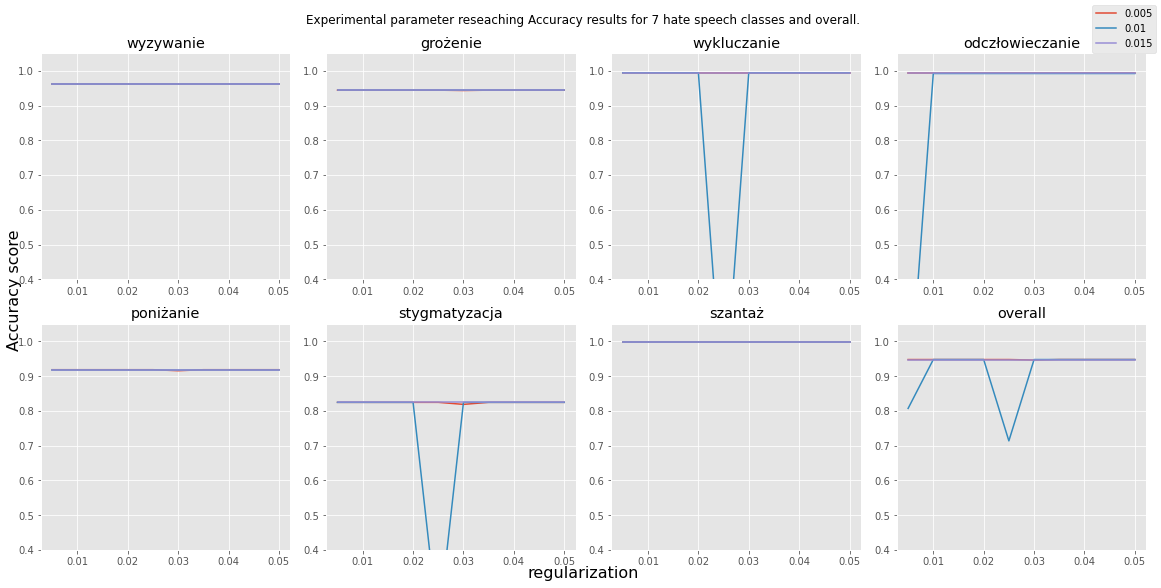

In [28]:
experimental_result_lines(df_results, series_names=learning_rates,
                          measure='a', shrink_to_interval=[0.4, 1.05],
                          save_file=EXPERIMENT_CHART_DIR.replace('{}', f'{EXPERIMENT}_a_lines'))

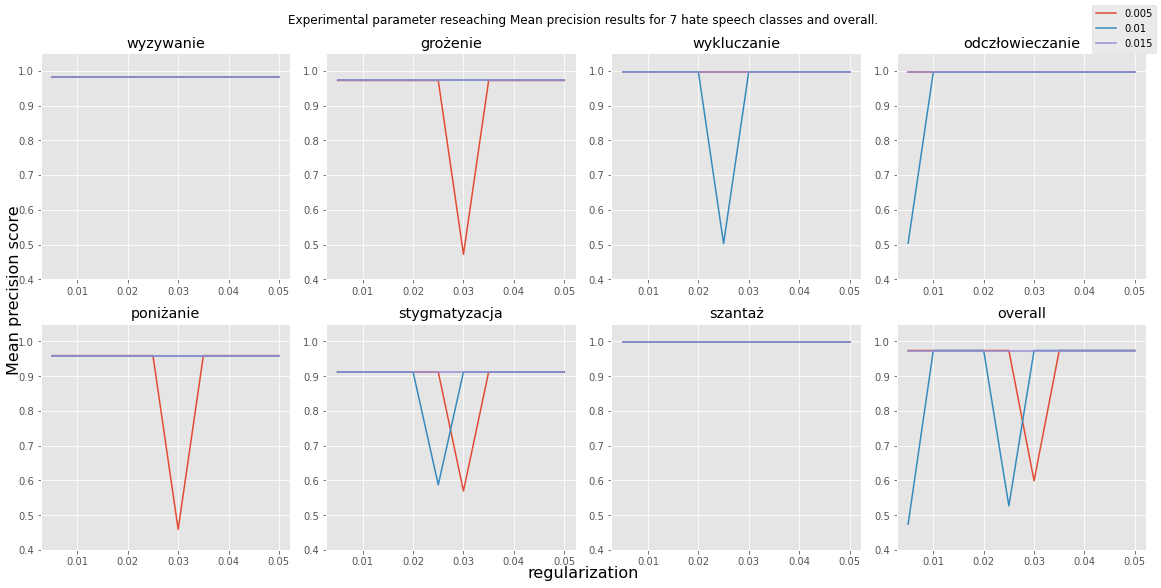

In [27]:
experimental_result_lines(df_results, series_names=learning_rates,
                          measure='p', shrink_to_interval=[0.4, 1.05],
                          save_file=EXPERIMENT_CHART_DIR.replace('{}', f'{EXPERIMENT}_p_lines'))

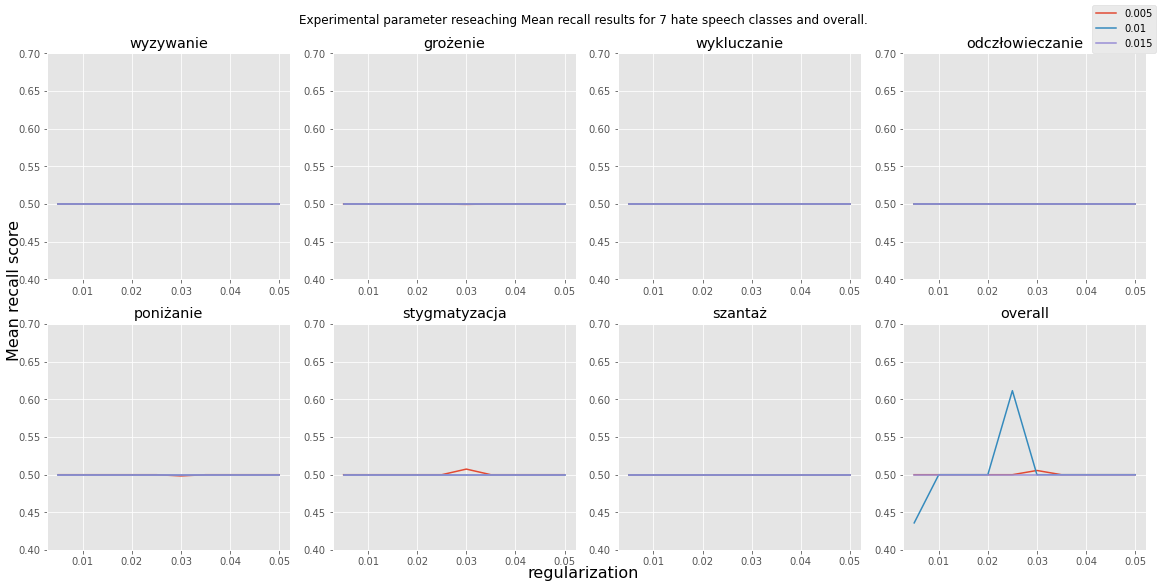

In [19]:
experimental_result_lines(df_results, series_names=learning_rates,
                          measure='r', shrink_to_interval=[0.4, 0.7],
                          save_file=EXPERIMENT_CHART_DIR.replace('{}', f'{EXPERIMENT}_r_lines'))

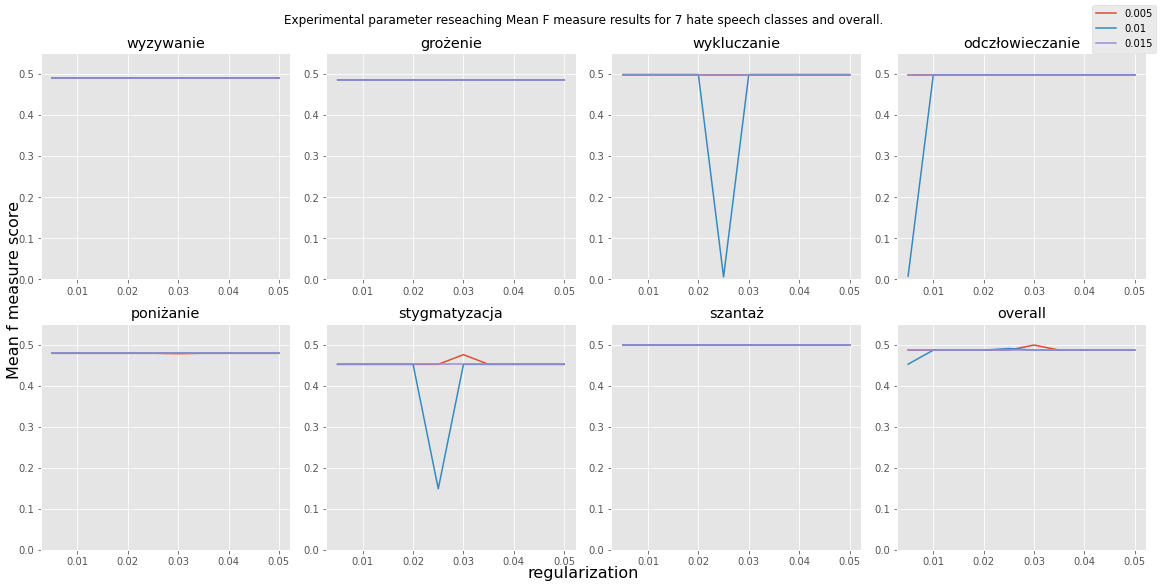

In [31]:
experimental_result_lines(df_results, series_names=learning_rates,
                          measure='f', shrink_to_interval=[0., 0.55],
                          save_file=EXPERIMENT_CHART_DIR.replace('{}', f'{EXPERIMENT}_f_lines'))

### Four quality measures

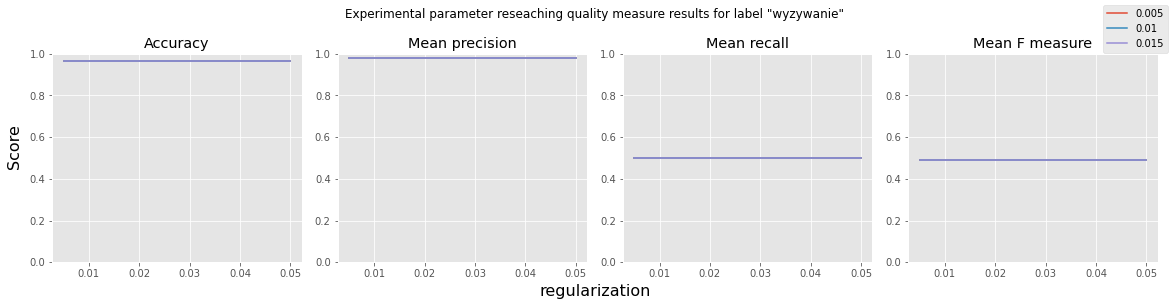

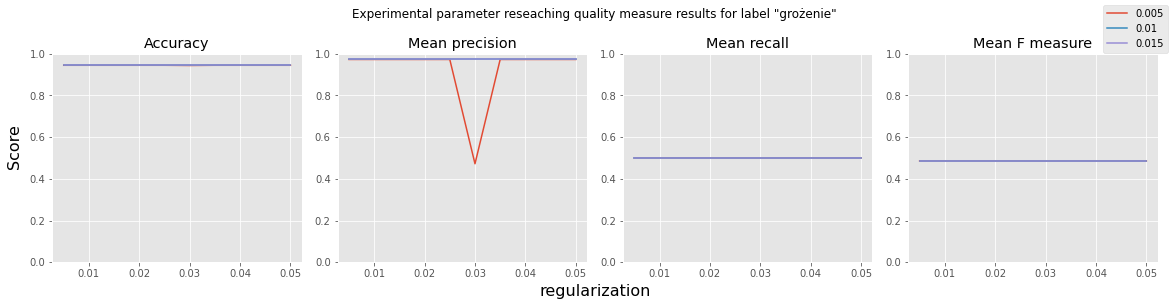

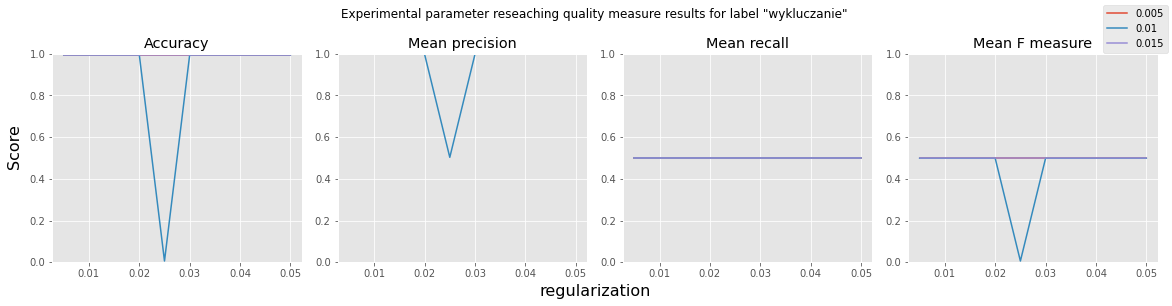

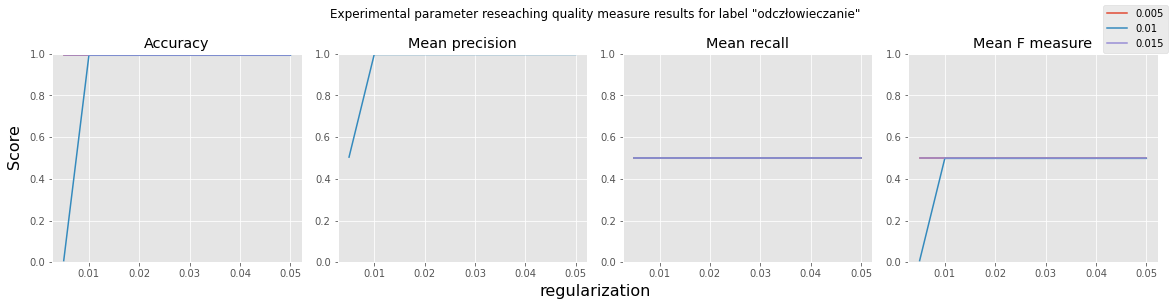

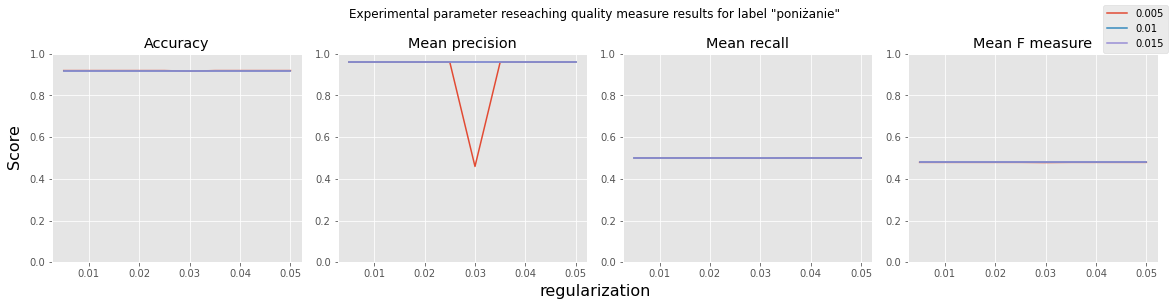

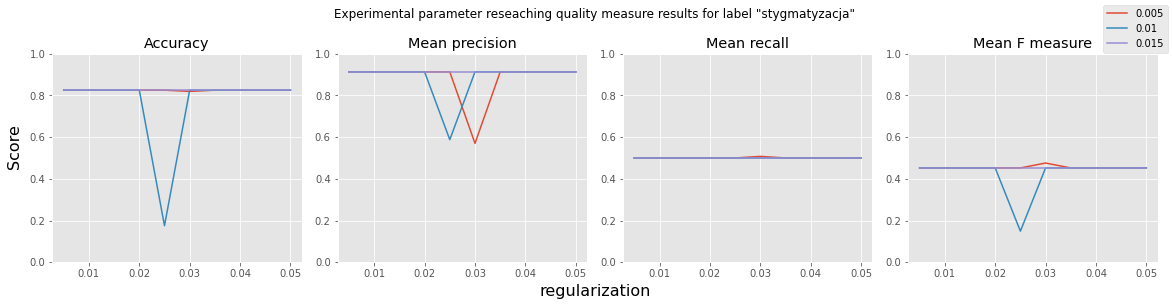

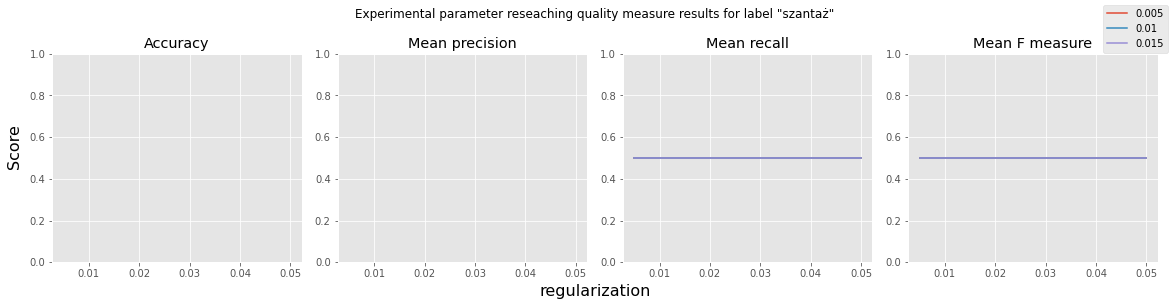

In [21]:
for label, lsmall in zip(LABELS, LABELS_SMALL):
    experimental_measure_lines(df_results, series_names=learning_rates,
                               label=label,
                               save_file=EXPERIMENT_CHART_DIR.replace('{}', f'{EXPERIMENT}_{lsmall}_lines'))